## Potato disease classification Using CNN
<img src="potato images.jpg" width=800 height=400 /><br>
- Dataset
  - Dataset containing 2152 images of Early_blight,Late_blight, and healthy potato leaf images
- Aim
  - My aim is to build a CNN model which can eaisly identify the disease of leaf early so farmers can save plant

In [30]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 15

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                           'PlantVillage',
                                            shuffle=True,
                                            image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                            batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

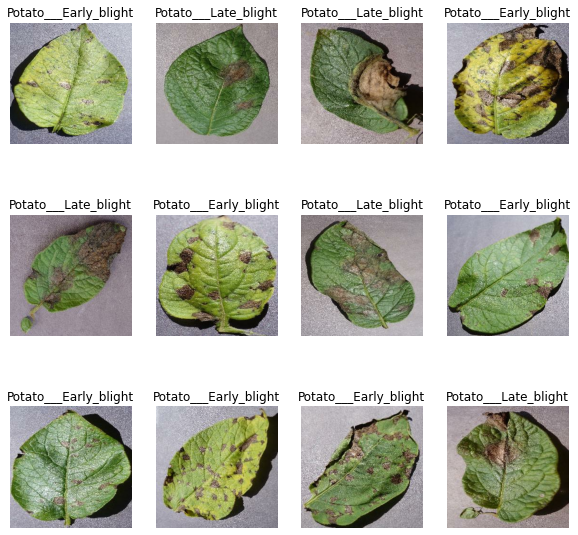

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('int'))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis('off')

80% ===> Training<br>
20% ===> 10% Validation, 10% Test 

### Spliting data into training, test and validation

In [7]:
def Train_test_val(ds,train_size = 0.8,test_size = 0.1,val_size = 0.1,shuffle=True,shuffle_size = 10000):
    
    ds_size = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
        
    train_size = int(0.8*ds_size)
    test_size = int(0.1*ds_size)
    
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size).skip(test_size)
    return train_ds,test_ds,val_ds

In [8]:
train_ds, test_ds, val_ds = Train_test_val(dataset)

In [9]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

54
6
8


### Prefetching
The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested.<br>
There is an argument that prefetch transformation requires — the number of elements to prefetch. However, we could simply make use of tf.data.AUTOTUNE— provided by tensorflow, which prompts tf.data runtime to tune the value dynamically at runtime.

### Caching
tf.data also have caching abilities with tf.data.Dataset.cache transformation. You can either cache a dataset in memory or in local storage. The rule of thumb will be to cache a small dataset in memory and a large dataset in local storage. This thus saves operation like file opening and data reading from being executed during each epoch — next epochs will reuse the data cached by the cache transformation.

One thing to note — you should cache after preprocessing (especially when these preprocessing functions are computational expensive) and before augmentation, as you would not want to store any randomness from your augmentations.

In [10]:
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(100).prefetch(buffer_size=tf.data.AUTOTUNE)

### Resize and Rescale

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

### Data Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
                layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                layers.experimental.preprocessing.RandomRotation(0.2)
                                        ])

### Model

In [18]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [20]:
model.compile(
    optimizer='Adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15
54/54 [==============================] - 105s 2s/step - loss: 0.8622 - accuracy: 0.5052 - val_loss: 0.6996 - val_accuracy: 0.6641
Epoch 2/15
54/54 [==============================] - 91s 2s/step - loss: 0.6206 - accuracy: 0.7054 - val_loss: 0.7535 - val_accuracy: 0.6602
Epoch 3/15
54/54 [==============================] - 89s 2s/step - loss: 0.4427 - accuracy: 0.8027 - val_loss: 0.4123 - val_accuracy: 0.8164
Epoch 4/15
54/54 [==============================] - 87s 2s/step - loss: 0.3404 - accuracy: 0.8623 - val_loss: 0.3381 - val_accuracy: 0.8594
Epoch 5/15
54/54 [==============================] - 88s 2s/step - loss: 0.2769 - accuracy: 0.8895 - val_loss: 0.3160 - val_accuracy: 0.8789
Epoch 6/15
54/54 [==============================] - 96s 2s/step - loss: 0.1983 - accuracy: 0.9288 - val_loss: 0.2684 - val_accuracy: 0.9062
Epoch 7/15
54/54 [==============================] - 91s 2s/step - loss: 0.2376 - accuracy: 0.9091 - val_loss: 0.2416 - val_accuracy: 0.8906
Epoch 8/15
54/54 [=

In [42]:
model.evaluate(test_ds)

6/6 [==============================] - 2s 374ms/step - loss: 0.1534 - accuracy: 0.9323


[0.15343482792377472, 0.9322916865348816]

### Saving Our Model

In [22]:
model.save('potato_dis.h5')

### Training Accuracy vs Validation Accuracy

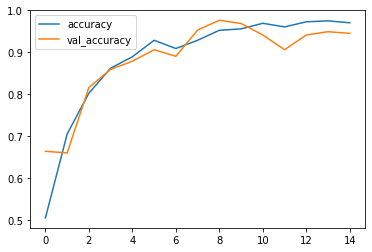

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])

### Training Loss vs Validation Loss

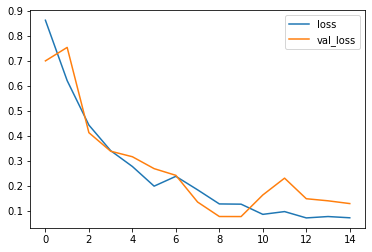

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

### Testing The Model

first image to predict
actual label:  Potato___Early_blight
predicted label:  Potato___Early_blight


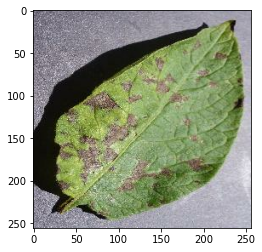

In [31]:
for image_batch,label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label: ',classes[first_label])
    
    batch_pred = model.predict(image_batch)
    print('predicted label: ',classes[np.argmax(batch_pred[0])])

In [36]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0) #creating a batch
    
    pred = model.predict(img_array)
    predicted_class =  classes[np.argmax(pred[0])]
    confidance = round(np.max(pred[0])*100)
    return predicted_class,confidance

### Prediction on Test Data

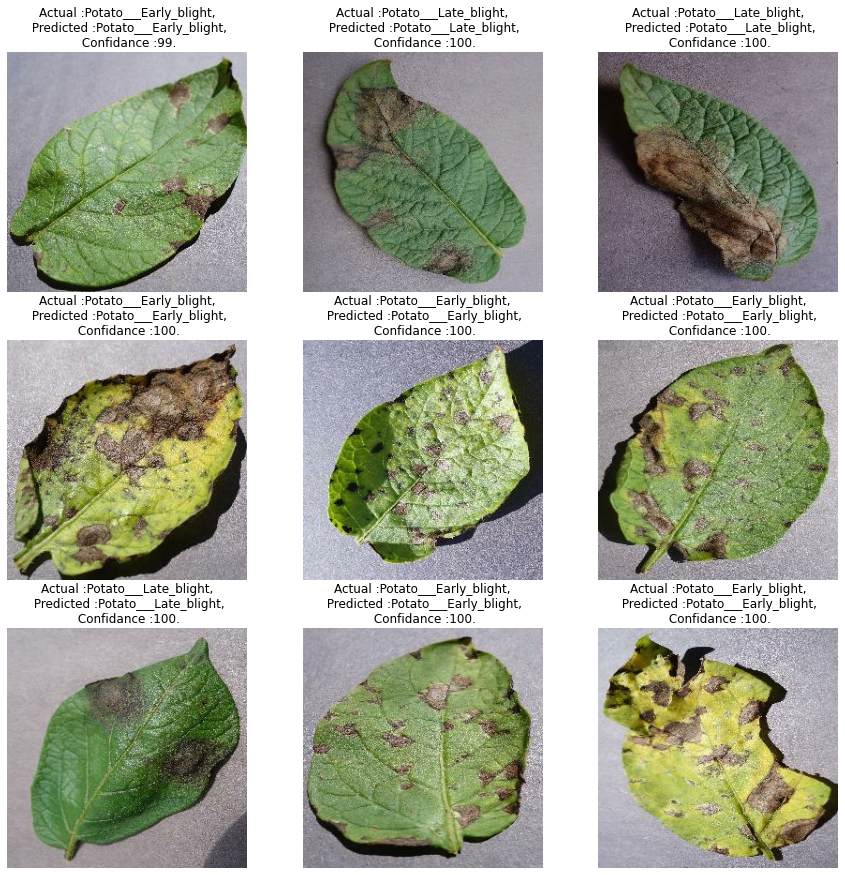

In [37]:
plt.figure(figsize=(15,15))
for image,label in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        
        predicted_class, confidance = predict(model,image[i].numpy())
        actual_class = classes[label[i]]
        
        plt.title(f'Actual :{actual_class},\n Predicted :{predicted_class},\n Confidance :{confidance}.')
        plt.axis('off')